In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [2]:
headers = "Cm,Ch,Bm,Bh,T,X,Y,Z,sR,sG,sB"
lut_path = r"D:\Github\PhD Code\Synthetic Data\monte_carlo\lut_rgb_BaseLine.csv"

df = pd.read_csv(lut_path, names=headers.split(","), header=None)

C:\Users\Aai\AppData\Local\Temp\ipykernel_45912\3831695973.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(lut_path, names=headers.split(","), header=None)


In [3]:
df

,Cm,Ch,Bm,Bh,T,X,Y,Z,sR,sG,sB
0,melanin_concentration(Cm),blood_concentration(Ch),melanin_blend(Bm),BloodOxy,epidermis_thickness(T),X,Y,Z,sR,sG,sB
1,0.001,0.001,0,0.627143,0.05,74.714,79.1013,73.3911,236.063,229.876,211.659
2,0.001,0.001,0,0.627143,0.09,74.8639,79.1686,73.8758,236.238,229.878,212.384
3,0.001,0.001,0,0.627143,0.17,75.0629,79.3771,74.2289,236.422,230.151,212.871
4,0.001,0.001,0,0.627143,0.01,74.6183,79.0106,73.1547,235.998,229.764,211.319
...,...,...,...,...,...,...,...,...,...,...,...
839996,0.5,0.32,1.0,0.98,0.13,1.6121,1.5696,1.20872,40.91,31.841,26.229
839997,0.5,0.32,1.0,0.98,0.25,1.43685,1.45939,1.237,36.375,31.36,26.903
839998,0.5,0.32,1.0,0.98,0.21,1.47819,1.48677,1.23741,37.431,31.514,26.859
839999,0.5,0.32,1.0,0.952857,0.05,2.22331,1.86828,1.28201,54.037,31.454,27.028


In [4]:
upper_bounds = [0.5, 0.32, 1.0, 0.98, 0.25]
lower_bounds = [0.001, 0.001, 0.0, 0.6, 0.01]

# Pair up the corresponding bounds and calculate their average
averages = [(u + l) / 2 for u, l in zip(upper_bounds, lower_bounds)]
avg_Cm, avg_Ch, avg_Bm, avg_Bh, avg_T = averages


#remove row 0
df = df.iloc[1:]
print(df.head())

#print length of df
print(len(df))
# convert all columns to float
for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

#convert sR, sG, sB to int
rounded_df = df.round({'sR': 0, 'sG': 0, 'sB': 0})
# Step 1: Find duplicate RGB values
duplicates = rounded_df[rounded_df.duplicated(subset=['sR', 'sG', 'sB'], keep=False)].copy() # added .copy()
#print all duplicates
print(duplicates.head())

# Step 2: Calculate the 'likelihood' score for each row
duplicates['likelihood'] = (abs(duplicates['Cm'] - avg_Cm) +
                            abs(duplicates['Ch'] - avg_Ch) +
                            abs(duplicates['Bm'] - avg_Bm) +
                            abs(duplicates['Bh'] - avg_Bh) +
                            abs(duplicates['T'] - avg_T))

# Step 3: Sort by RGB values and likelihood, keeping the row with the lowest likelihood for each RGB group
most_likely_duplicates = duplicates.sort_values(['sR', 'sG', 'sB', 'likelihood']).drop_duplicates(subset=['sR', 'sG', 'sB'])

# Now, most_likely_duplicates should contain your desired rows

# First, remove all duplicates from the original dataframe
df_no_duplicates = df.drop_duplicates(subset=['sR', 'sG', 'sB'], keep=False)

# Concatenate df_no_duplicates with most_likely_duplicates to get the final dataframe
df = pd.concat([df_no_duplicates, most_likely_duplicates])

# If you want to sort it based on index
df.sort_index(inplace=True)
df.head()
#remove duplicates

x = df[['sR', 'sG', 'sB']].to_numpy(dtype='float32')
y = df[['Cm', 'Ch', 'Bm', 'Bh', 'T']].to_numpy(dtype='float32')
#create new csv with headers
# df.to_csv(r'LUTs\large_no_duplicates.csv', index=False, header=True)


#train nn on x,y
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
#remove any header values
x_train = x_train[1:]
x_test = x_test[1:]
y_train = y_train[1:]
y_test = y_test[1:]

#numpy arrays
x_train = np.asarray(x_train).reshape(-1,3).astype('float32')
x_test = np.asarray(x_test).reshape(-1,3).astype('float32')
print(f"length of df {len(df)}")
print(f"bef norm x_train[0] {x_train[0]}")

#normalize
x_train = x_train/255.0
x_test = x_test/255.0
print(f"aft norm x_train[0] {x_train[0]}")

print(f"length of x_train {len(x_train)}")
print(f"length of x_test {len(x_test)}")
print(f"length of y_train {len(y_train)}")
print(f"length of y_test {len(y_test)}")
df.head()
print(f"length of df {len(df)}")
#print random 3 rows
#print unique values of Cm,Ch,Bm,Bh,T
# print(f"unique Cm {df['Cm'].unique()}")
# print(f"unique Ch {df['Ch'].unique()}")
# print(f"unique Bm {df['Bm'].unique()}")
# print(f"unique Bh {df['Bh'].unique()}")
# print(f"unique T {df['T'].unique()}")
#as sorted lists
C_m = sorted(df['Cm'].unique())
C_h = sorted(df['Ch'].unique())
B_m = sorted(df['Bm'].unique())
B_h = sorted(df['Bh'].unique())
T = sorted(df['T'].unique())
print(f"Cm = {C_m}")
print(f"Ch = {C_h}")
print(f"Bm = {B_m}")
print(f"Bh = {B_h}")
print(f"T = {T}")
#min max for each
min_vals = [min(C_m), min(C_h), min(B_m), min(B_h), min(T)]
max_vals = [max(C_m), max(C_h), max(B_m), max(B_h), max(T)]
print(f"upper bounds = {max_vals}")
print(f"lower bounds = {min_vals}")
#integer arrays for sR,sG,sB 0 to 255
# Assuming df is your DataFrame and it has columns 'sR', 'sG', 'sB'
df[['sR', 'sG', 'sB']] = df[['sR', 'sG', 'sB']].astype(float)
df[['sR', 'sG', 'sB']] = df[['sR', 'sG', 'sB']].applymap(np.round)
# Add a 'count' column that counts the number of identical RGB values
df['count'] = df.groupby(['sR', 'sG', 'sB'])['sR'].transform('count')
print(f"number of repeated RGB values {len(df[df['count'] > 1])}")

C:\Users\Aai\AppData\Local\Temp\ipykernel_45912\3995564710.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_numeric(df[column], errors='coerce')


      Cm     Ch Bm        Bh     T        X        Y        Z       sR  \
1  0.001  0.001  0  0.627143  0.05   74.714  79.1013  73.3911  236.063   
2  0.001  0.001  0  0.627143  0.09  74.8639  79.1686  73.8758  236.238   
3  0.001  0.001  0  0.627143  0.17  75.0629  79.3771  74.2289  236.422   
4  0.001  0.001  0  0.627143  0.01  74.6183  79.0106  73.1547  235.998   
5  0.001  0.001  0  0.627143  0.13  75.0411  79.2762  74.4091  236.415   

        sG       sB  
1  229.876  211.659  
2  229.878  212.384  
3  230.151  212.871  
4  229.764  211.319  
5  229.945  213.169  
840000
      Cm     Ch   Bm        Bh     T        X        Y        Z     sR     sG  \
1  0.001  0.001  0.0  0.627143  0.05  74.7140  79.1013  73.3911  236.0  230.0   
2  0.001  0.001  0.0  0.627143  0.09  74.8639  79.1686  73.8758  236.0  230.0   
3  0.001  0.001  0.0  0.627143  0.17  75.0629  79.3771  74.2289  236.0  230.0   
4  0.001  0.001  0.0  0.627143  0.01  74.6183  79.0106  73.1547  236.0  230.0   
5  0.001  0

C:\Users\Aai\AppData\Local\Temp\ipykernel_45912\3995564710.py:106: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[['sR', 'sG', 'sB']] = df[['sR', 'sG', 'sB']].applymap(np.round)


number of repeated RGB values 930979


In [5]:
# -----------------------------
# Reproducibility (np.random.seed(7) equivalent)
# -----------------------------
np.random.seed(7)
torch.manual_seed(7)
torch.cuda.manual_seed_all(7)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -----------------------------
# Hyperparameters (from your code)
# -----------------------------
BATCH_SIZE = 4096 * 16
NUM_NEURONS = 75
NUM_LAYERS = 2
NUM_EPOCHS = 200
LR = 1e-4
MLR = 1e-6  # unused in your compile; keeping for parity

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader

class AEDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y).float()
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x_i = self.x[idx]   # [3]
        y_i = self.y[idx]   # [5]
        
        enc_in = x_i
        dec_in = y_i
        end_in = x_i
        
        enc_true = y_i
        dec_true = x_i
        end_true = x_i
        
        return enc_in, dec_in, end_in, enc_true, dec_true, end_true


# Create train and validation datasets
train_dataset = AEDataset(x_train, y_train)
val_dataset = AEDataset(x_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# DEBUG: Let's see what the dataloader is actually giving us
print("Checking train_loader...")
for batch in train_loader:
    print(f"Batch contains {len(batch)} tensors")
    for i, item in enumerate(batch):
        print(f"  Item {i}: shape = {item.shape if hasattr(item, 'shape') else 'NO SHAPE'}, type = {type(item)}")
    break  # Just check first batch

print("\nChecking val_loader...")
for batch in val_loader:
    print(f"Batch contains {len(batch)} tensors")
    for i, item in enumerate(batch):
        print(f"  Item {i}: shape = {item.shape if hasattr(item, 'shape') else 'NO SHAPE'}, type = {type(item)}")
    break


Checking train_loader...
Batch contains 6 tensors
  Item 0: shape = torch.Size([65536, 3]), type = <class 'torch.Tensor'>
  Item 1: shape = torch.Size([65536, 5]), type = <class 'torch.Tensor'>
  Item 2: shape = torch.Size([65536, 3]), type = <class 'torch.Tensor'>
  Item 3: shape = torch.Size([65536, 5]), type = <class 'torch.Tensor'>
  Item 4: shape = torch.Size([65536, 3]), type = <class 'torch.Tensor'>
  Item 5: shape = torch.Size([65536, 3]), type = <class 'torch.Tensor'>

Checking val_loader...
Batch contains 6 tensors
  Item 0: shape = torch.Size([65536, 3]), type = <class 'torch.Tensor'>
  Item 1: shape = torch.Size([65536, 5]), type = <class 'torch.Tensor'>
  Item 2: shape = torch.Size([65536, 3]), type = <class 'torch.Tensor'>
  Item 3: shape = torch.Size([65536, 5]), type = <class 'torch.Tensor'>
  Item 4: shape = torch.Size([65536, 3]), type = <class 'torch.Tensor'>
  Item 5: shape = torch.Size([65536, 3]), type = <class 'torch.Tensor'>


In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import os

def show_training_progress(encoder, decoder, x_batch, y_batch, device, epoch, save_dir):
    """
    Shows RGB → Encoder → Latent → Decoder → RGB
    Saves visualization to file and returns metrics
    """
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        latent_predicted = encoder(x_batch[:3])
        rgb_output = decoder(latent_predicted)
    
    # Convert to readable format
    rgb_input = (x_batch[:3].cpu().numpy() * 255).astype(int)
    latent_pred = latent_predicted.cpu().numpy()
    latent_true = y_batch[:3].cpu().numpy()
    rgb_recon = (rgb_output.cpu().numpy() * 255).astype(int)
    
    # Create plot
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    fig.suptitle(f'Epoch {epoch} - Training Progress', fontsize=14, fontweight='bold')
    
    params = ['Cm', 'Ch', 'Bm', 'Bh', 'T']
    
    for i in range(3):
        # Input color
        axes[i,0].imshow([[rgb_input[i]/255.0]])
        axes[i,0].set_title(f'Input\n{rgb_input[i]}')
        axes[i,0].axis('off')
        
        # True parameters
        axes[i,1].barh(params, latent_true[i], color='green', alpha=0.6)
        axes[i,1].set_xlim(0,1)
        axes[i,1].set_title('True Parameters')
        
        # Predicted parameters
        axes[i,2].barh(params, latent_pred[i], color='orange', alpha=0.6)
        axes[i,2].set_xlim(0,1)
        axes[i,2].set_title('Encoder Output')
        
        # Reconstructed color
        axes[i,3].imshow([[rgb_recon[i]/255.0]])
        axes[i,3].set_title(f'Output\n{rgb_recon[i]}')
        axes[i,3].axis('off')
        
        # Error
        error = np.abs(rgb_input[i] - rgb_recon[i])
        axes[i,4].axis('off')
        axes[i,4].text(0.1, 0.5, f'Error:\n{error}\n\nAvg: {error.mean():.1f}',
                      fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat'))
    
    plt.tight_layout()
    
    # SAVE to file
    save_path = os.path.join(save_dir, f'epoch_{epoch:04d}.png')
    plt.savefig(save_path, dpi=100, bbox_inches='tight')
    plt.close()
    
    # Return metrics for logging
    metrics = []
    for i in range(3):
        error = np.abs(rgb_input[i] - rgb_recon[i])
        metrics.append({
            'sample': i,
            'rgb_input': rgb_input[i].tolist(),
            'rgb_output': rgb_recon[i].tolist(),
            'mean_error': float(error.mean())
        })
    
    return metrics

In [ ]:
import os
import time
from datetime import datetime

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import json


# -----------------------------
# DEVICE
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# -----------------------------
# MODEL COMPONENTS
# -----------------------------
class Encoder(nn.Module):
    def __init__(self, in_dim=3, hidden_dim=NUM_NEURONS, num_layers=NUM_LAYERS, out_dim=5):
        super().__init__()
        layers = []
        for i in range(num_layers):
            layers.append(nn.Linear(in_dim if i == 0 else hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        self.mlp = nn.Sequential(*layers)
        self.out = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = self.mlp(x)
        return self.out(x)


class Decoder(nn.Module):
    def __init__(self, in_dim=5, hidden_dim=NUM_NEURONS, num_layers=NUM_LAYERS, out_dim=3):
        super().__init__()
        layers = []
        for i in range(num_layers):
            layers.append(nn.Linear(in_dim if i == 0 else hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        self.mlp = nn.Sequential(*layers)
        self.out = nn.Linear(hidden_dim, out_dim)

    def forward(self, x):
        x = self.mlp(x)
        return self.out(x)


class AutoEncoder(nn.Module):
    def __init__(self, encoder: nn.Module, decoder: nn.Module):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, encoder_in, decoder_in, end_to_end_in):
        enc_out = self.encoder(encoder_in)
        dec_out = self.decoder(decoder_in)
        end_out = self.decoder(self.encoder(end_to_end_in))
        return enc_out, dec_out, end_out





# -----------------------------
# Loss functions (same as before)
# -----------------------------
def albedo_loss(y_true, y_pred):
    return torch.sum(torch.abs(y_pred - y_true), dim=-1)

def parameter_loss(y_true, y_pred):
    return torch.sqrt(torch.sum((y_pred - y_true) ** 2, dim=-1) + 1e-12)

def end_to_end_loss(y_true, y_pred):
    return torch.sum(torch.abs(y_pred - y_true), dim=-1)

def reduce_loss(loss_per_sample, reduction="mean"):
    if reduction == "mean":
        return loss_per_sample.mean()
    elif reduction == "sum":
        return loss_per_sample.sum()
    else:
        raise ValueError("reduction must be 'mean' or 'sum'")


# -----------------------------
# Run folder creation (date/time)
# -----------------------------
def create_run_folder(base_dir="checkpoints"):
    now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    run_dir = os.path.join(base_dir, now)
    os.makedirs(run_dir, exist_ok=True)
    return run_dir


# -----------------------------
# Evaluation loop (val)
# -----------------------------
def evaluate(model, dataloader, loss_weights=(0.3, 0.1, 0.6)):
    model.eval()

    total_loss_sum = 0.0
    loss1_sum = 0.0
    loss2_sum = 0.0
    loss3_sum = 0.0
    n_batches = 0

    with torch.no_grad():
        for batch in dataloader:
            enc_in, dec_in, end_in, enc_true, dec_true, end_true = batch

            enc_in   = enc_in.to(device)
            dec_in   = dec_in.to(device)
            end_in   = end_in.to(device)
            enc_true = enc_true.to(device)
            dec_true = dec_true.to(device)
            end_true = end_true.to(device)

            enc_pred, dec_pred, end_pred = model(enc_in, dec_in, end_in)

            loss1 = reduce_loss(parameter_loss(enc_true, enc_pred), "mean")
            loss2 = reduce_loss(albedo_loss(dec_true, dec_pred), "mean")
            loss3 = reduce_loss(end_to_end_loss(end_true, end_pred), "mean")

            total_loss = loss_weights[0]*loss1 + loss_weights[1]*loss2 + loss_weights[2]*loss3

            total_loss_sum += total_loss.item()
            loss1_sum += loss1.item()
            loss2_sum += loss2.item()
            loss3_sum += loss3.item()
            n_batches += 1

    if n_batches == 0:
        return {"total": 0.0, "loss1": 0.0, "loss2": 0.0, "loss3": 0.0}

    return {
        "total": total_loss_sum / n_batches,
        "loss1": loss1_sum / n_batches,
        "loss2": loss2_sum / n_batches,
        "loss3": loss3_sum / n_batches,
    }


# -----------------------------
# Training loop (train + val)
# -----------------------------
def train(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    num_epochs=200,
    loss_weights=(0.3, 0.1, 0.6),
    base_ckpt_dir="checkpoints",
    checkpoint_period=200,
    print_period=25,
    save_json_each_epoch=True,
):
    run_dir = create_run_folder(base_ckpt_dir)
    best_ckpt_path = os.path.join(run_dir, "best.pt")
    last_ckpt_path = os.path.join(run_dir, "last.pt")
    json_path = os.path.join(run_dir, "history.json")

    print("Using device:", device)
    print("Run folder:", run_dir)

    # CREATE VISUALIZATION FOLDER
    viz_dir = os.path.join(run_dir, "visualizations")
    os.makedirs(viz_dir, exist_ok=True)
    
    # CREATE LOG FILE
    log_file_path = os.path.join(viz_dir, "training_log.txt")
    with open(log_file_path, 'w') as f:
        f.write("="*80 + "\n")
        f.write("AUTOENCODER TRAINING LOG\n")
        f.write("="*80 + "\n")
        f.write(f"Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Device: {device}\n")
        f.write(f"Number of Epochs: {num_epochs}\n")
        f.write(f"Batch Size: {train_loader.batch_size}\n")
        f.write("="*80 + "\n\n")

    print("Using device:", device)
    print("Run folder:", run_dir)
    print("Visualizations folder:", viz_dir)
    print("Training log:", log_file_path)

    best_train_loss = float("inf")

    history = {
        "config": {
            "num_epochs": num_epochs,
            "loss_weights": loss_weights,
            "optimizer": optimizer.__class__.__name__,
            "scheduler": scheduler.__class__.__name__,
            "device": str(device),
        },
        "epochs": []
    }

    for epoch in range(num_epochs):
        model.train()

        total_loss_sum = 0.0
        loss1_sum = 0.0
        loss2_sum = 0.0
        loss3_sum = 0.0
        n_batches = 0

        for batch in train_loader:
            enc_in, dec_in, end_in, enc_true, dec_true, end_true = batch

            enc_in   = enc_in.to(device)
            dec_in   = dec_in.to(device)
            end_in   = end_in.to(device)
            enc_true = enc_true.to(device)
            dec_true = dec_true.to(device)
            end_true = end_true.to(device)

            optimizer.zero_grad()

            enc_pred, dec_pred, end_pred = model(enc_in, dec_in, end_in)

            loss1 = reduce_loss(parameter_loss(enc_true, enc_pred), "mean")
            loss2 = reduce_loss(albedo_loss(dec_true, dec_pred), "mean")
            loss3 = reduce_loss(end_to_end_loss(end_true, end_pred), "mean")

            total_loss = loss_weights[0]*loss1 + loss_weights[1]*loss2 + loss_weights[2]*loss3

            total_loss.backward()
            optimizer.step()

            total_loss_sum += total_loss.item()
            loss1_sum += loss1.item()
            loss2_sum += loss2.item()
            loss3_sum += loss3.item()
            n_batches += 1

        train_stats = {
            "total": total_loss_sum / max(n_batches, 1),
            "loss1": loss1_sum / max(n_batches, 1),
            "loss2": loss2_sum / max(n_batches, 1),
            "loss3": loss3_sum / max(n_batches, 1),
        }

        val_stats = evaluate(model, val_loader, loss_weights=loss_weights)

        # Keras ReduceLROnPlateau monitors train loss in your code
        scheduler.step(train_stats["total"])
        current_lr = optimizer.param_groups[0]["lr"]

        # Logging record for this epoch
        epoch_record = {
            "epoch": epoch,
            "lr": current_lr,
            "train": train_stats,
            "val": val_stats,
        }
        history["epochs"].append(epoch_record)

        # Save JSON file continuously (optional)
        if save_json_each_epoch:
            with open(json_path, "w") as f:
                json.dump(history, f, indent=6)

       
        # Print callback every N epochs
        # Print callback every N epochs
        if epoch % print_period == 0:
            print(
                f"epoch: {epoch} | "
                f"train_total={train_stats['total']:.6f} "
                f"(L1={train_stats['loss2']:.6f}, L2={train_stats['loss1']:.6f}, end={train_stats['loss3']:.6f}) | "
                f"val_total={val_stats['total']:.6f} "
                f"(L1={val_stats['loss2']:.6f}, L2={val_stats['loss1']:.6f}, end={val_stats['loss3']:.6f}) | "
                f"lr={current_lr:.2e}"
            )

        # VISUALIZE EVERY EPOCH (not just print_period)
        for val_batch in val_loader:
            break
        end_in, end_true = val_batch[2], val_batch[5]

        vis_metrics = show_training_progress(
            model.encoder, 
            model.decoder, 
            end_in.to(device), 
            end_true.to(device), 
            device, 
            epoch,
            viz_dir
        )

        # LOG TO TEXT FILE EVERY EPOCH
        with open(log_file_path, 'a') as f:
            f.write(f"\n{'='*80}\n")
            f.write(f"EPOCH {epoch}\n")
            f.write(f"{'='*80}\n")
            f.write(f"Train Loss:  {train_stats['total']:.6f} ")
            f.write(f"(param={train_stats['loss1']:.6f}, albedo={train_stats['loss2']:.6f}, e2e={train_stats['loss3']:.6f})\n")
            f.write(f"Val Loss:    {val_stats['total']:.6f} ")
            f.write(f"(param={val_stats['loss1']:.6f}, albedo={val_stats['loss2']:.6f}, e2e={val_stats['loss3']:.6f})\n")
            f.write(f"LR:          {current_lr:.2e}\n")
            f.write(f"Viz Errors:  ")
            for m in vis_metrics:
                f.write(f"Sample{m['sample']}={m['mean_error']:.2f} ")
            f.write(f"\nImage saved: epoch_{epoch:04d}.png\n")


        # Save BEST model (like ModelCheckpoint(save_best_only=True))
        if train_stats["total"] < best_train_loss:
            best_train_loss = train_stats["total"]
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "best_train_loss": best_train_loss,
                    "history_path": json_path,
                },
                best_ckpt_path,
            )

        # Save periodic checkpoint (every checkpoint_period epochs)
        if (epoch + 1) % checkpoint_period == 0:
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "train_total_loss": train_stats["total"],
                    "val_total_loss": val_stats["total"],
                    "history_path": json_path,
                },
                last_ckpt_path,
            )

    # final save JSON (ensures up-to-date)
    with open(json_path, "w") as f:
        json.dump(history, f, indent=6)

   # FINAL LOG ENTRY
    with open(log_file_path, 'a') as f:
        f.write(f"\n{'='*80}\n")
        f.write("TRAINING COMPLETE\n")
        f.write(f"{'='*80}\n")
        f.write(f"End Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Best Training Loss: {best_train_loss:.6f}\n")
        f.write(f"Total Visualizations: {num_epochs}\n")

    print("\nTraining complete!")
    print(f"All {num_epochs} visualizations saved in: {viz_dir}")
    print(f"Training log: {log_file_path}")

    return history, run_dir


Using device: cuda
Run folder: checkpoints\2026-02-24_14-11-42
Using device: cuda
Run folder: checkpoints\2026-02-24_14-11-42
Visualizations folder: checkpoints\2026-02-24_14-11-42\visualizations
Training log: checkpoints\2026-02-24_14-11-42\visualizations\training_log.txt
epoch: 0 | train_total=1.178348 (L1=1.272290, L2=0.963346, end=1.270191) | val_total=1.149902 (L1=1.240290, L2=0.941673, end=1.238951) | lr=1.00e-04


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (3,) and arg 3 with shape (5,).

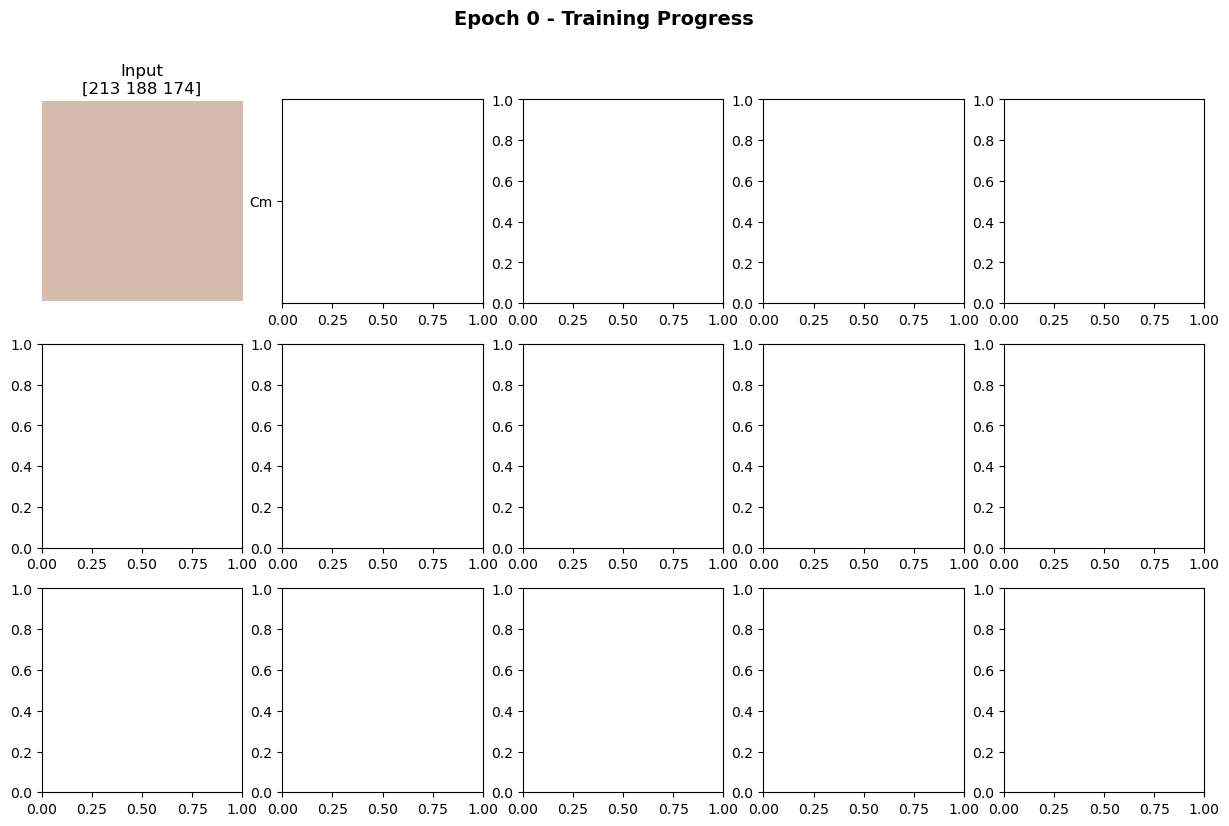

In [9]:
encoder_net = Encoder().to(device)
decoder_net = Decoder().to(device)
model = AutoEncoder(encoder_net, decoder_net).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.01,
    patience=5,
    threshold=1e-4,
    cooldown=0,
    min_lr=MLR,
)

history, run_dir = train(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
    loss_weights=(0.3, 0.1, 0.6),
    base_ckpt_dir="checkpoints",
    checkpoint_period=200,
    print_period=5,
    save_json_each_epoch=True,
)

best_checkpoint = os.path.join(run_dir, "best.pt")
print("Best checkpoint saved at:", best_checkpoint)
print("Run directory:", run_dir)


In [ ]:
import numpy as np
import torch
import time
import math

# device setup (equivalent to tf.device('/device:GPU:0'))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Make sure encoder / decoder are already defined and moved to device:
# encoder.to(device)
# decoder.to(device)
# encoder.eval()
# decoder.eval()


def encode(image, encoder):
    """
    PyTorch version of TensorFlow encode()
    Input: image (numpy array), encoder (torch.nn.Module)
    Output: pred_maps (numpy), elapsed (float), (WIDTH, HEIGHT)
    """
    print(f"Image shape at start of encoder method: {image.shape}")

    # Handle 2D flattened input vs image input
    if len(image.shape) == 2:
        WIDTH = HEIGHT = int(math.sqrt(image.shape[0]))
        # your code: reshape(-1,4) then later reshape(W*H,3)
        # This implies the 4th channel was ignored later.
        # We'll keep it identical:
        image = np.asarray(image).reshape(-1, 4).astype("float32")
    else:
        WIDTH = image.shape[0]
        HEIGHT = image.shape[1]
        image = np.asarray(image).astype("float32")

    # match your Keras reshape
    image = image.reshape(WIDTH * HEIGHT, 3)

    start = time.time()
    print(f"Image shape before encoder inference: {image.shape}")

    # Convert to torch tensor and run model inference
    x = torch.from_numpy(image).to(device)

    encoder.eval()
    with torch.no_grad():
        pred_maps = encoder(x)

    # Convert back to numpy
    pred_maps = pred_maps.detach().cpu().numpy()

    end = time.time()
    elapsed = end - start

    # reshape output to (WIDTH*HEIGHT, 5)
    pred_maps = pred_maps.reshape(WIDTH * HEIGHT, 5)

    return pred_maps, elapsed, (WIDTH, HEIGHT)


def decode(encoded, decoder):
    """
    PyTorch version of TensorFlow decode()
    Input: encoded (numpy array), decoder (torch.nn.Module)
    Output: recovered (numpy), elapsed (float), (WIDTH, HEIGHT)
    """
    print(f"Image shape going into encoder: {encoded.shape}")

    start = time.time()

    # Handle 2D flattened input vs (W,H,C) style input
    if len(encoded.shape) == 2:
        WIDTH = HEIGHT = int(math.sqrt(encoded.shape[0]))
        encoded = np.asarray(encoded).reshape(-1, 5).astype("float32")
    else:
        WIDTH = encoded.shape[0]
        HEIGHT = encoded.shape[1]
        encoded = np.asarray(encoded).astype("float32")

    print(f"encoded shape going into decoder: {encoded.shape}")

    # Torch inference
    x = torch.from_numpy(encoded).to(device)

    decoder.eval()
    with torch.no_grad():
        recovered = decoder(x)

    recovered = recovered.detach().cpu().numpy()

    end = time.time()
    elapsed = end - start

    # reshape output to RGB image
    recovered = recovered.reshape(WIDTH, HEIGHT, 3)

    return recovered, elapsed, (WIDTH, HEIGHT)
